In [3]:
import numpy as np
np.random.seed(42)
import pandas as pd
import string
import re
import matplotlib.pyplot as plt

import gensim
from collections import Counter
import pickle

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, hamming_loss, f1_score

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from keras.preprocessing import text, sequence
from keras import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras
import seaborn as sns

In [4]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
dir = "drive/My Drive/BT4221/Data/"
df = pd.read_csv(dir+"cleaned_train_v1.csv")
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,char_count,word_density,total_length,capitals,capitals_prop,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words,prop_unique_words,processed_text,polarity,subjectivity
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,-0.244844,-0.211930,-0.493930,-0.220419,-0.001684,0.137612,-0.025544,0.346355,-0.154764,-0.107174,-0.130716,0.768622,explanation edits made username hardcore metal...,0.272671,0.262369
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,-0.506830,-0.471943,-0.930063,-0.477701,-0.094912,0.213387,0.013059,-0.282543,-0.233058,-0.107174,-0.571564,1.131563,daww match background colour seemingly stuck t...,0.535212,-0.674041
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,-0.254920,-0.274902,0.257890,-0.272891,-0.136347,-0.371094,-0.025544,-0.282543,-0.311352,-0.107174,-0.167453,0.574190,hey man really trying edit war guy constantly ...,0.328930,0.000397
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0.460504,0.373099,0.348351,0.385547,-0.063836,-0.365520,-0.025544,-0.282543,-0.154764,-0.107174,0.622401,-1.009142,ca nt make real suggestion improvement wondere...,0.466452,-0.316384
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,-0.547136,-0.553197,0.683628,-0.553870,-0.157064,-0.234474,-0.025544,0.346355,-0.389645,-0.107174,-0.645039,1.131563,sir hero chance remember page,-0.289916,-1.409792


In [6]:
!curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  27.6M      0  0:00:52  0:00:52 --:--:-- 28.9M
crawl-300d-2M.vec.zip  drive  sample_data


In [7]:
!unzip crawl-300d-2M.vec.zip

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [11]:
# Load the FastText Web Crawl vectors
EMBEDDING_FILE_FASTTEXT="crawl-300d-2M.vec"
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE_FASTTEXT,encoding='utf-8'))

## Load Data

In [16]:
## split dataset
train, test = train_test_split(df, test_size=0.2, random_state=1234)

X_train = train["processed_text"]
X_test = test["processed_text"]
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values


In [47]:
# Add feature engineering
features = train.iloc[:, 9:24].drop(columns=['processed_text'])
test_features = test.iloc[:, 9:24].drop(columns=['processed_text'])

In [49]:
features.head()

,word_count,char_count,word_density,total_length,capitals,capitals_prop,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words,prop_unique_words,polarity,subjectivity
92705,-0.577365,-0.559291,-0.590208,-0.564026,-0.177782,-0.556015,-0.025544,0.346355,-0.624527,-0.107174,-0.700145,1.131563,0.397691,-0.183540
153723,0.148136,0.127305,0.026417,0.133343,0.019033,-0.123328,-0.025544,-0.282543,-0.233058,-0.107174,-0.057241,-2.389400,-0.083634,-1.017392
138916,-0.355684,-0.380532,0.531446,-0.376143,-0.043119,0.258119,-0.025544,-0.282543,-0.233058,-0.107174,-0.296034,1.131563,1.231414,1.211321
47504,-0.023163,-0.102237,0.732575,-0.088393,-0.136347,-0.430031,-0.025544,0.346355,-0.154764,-0.107174,0.052971,-0.549130,-0.106554,-0.347041
92139,-0.456448,-0.348031,-2.013172,-0.367679,-0.084554,-0.008305,-0.025544,-0.282543,-0.076471,-0.107174,-0.498090,0.776871,-0.289916,-1.409792


In [38]:
vocab_size = 10000
max_length = 200

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(X_train) + list(X_test))

X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

x_train = sequence.pad_sequences(X_train_sequence, maxlen=max_length)
x_test = sequence.pad_sequences(X_test_sequence, maxlen=max_length)
print(len(tokenizer.word_index))

189230


In [39]:
word_index = tokenizer.word_index
embedding_dim = 300

# Build embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18340001,  0.1092    , -0.0946    , ...,  0.0157    ,
         0.20290001,  0.1182    ],
       [ 0.44310001,  0.28369999, -0.54750001, ..., -0.0851    ,
        -0.54110003,  0.29660001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.78170002, -0.0237    ,  0.2807    , ..., -0.0452    ,
         0.098     , -0.2022    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [65]:
def get_model(features):
    features_input = Input(shape=(features.shape[1],))
    inp = Input(shape=(max_length, ))
    
    # Layer 1: Embedding Layer
    x = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(inp)

    # Layer 2: Bidirectional LSTM
    x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)

    # Layer 3: A concatenation of maximum pool and engineered features
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool, features_input])
    x = BatchNormalization()(x)

    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    
    # Output dense layer.
    outp = Dense(6, activation="sigmoid")(x)

    model = Model(inputs=[inp,features_input], outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

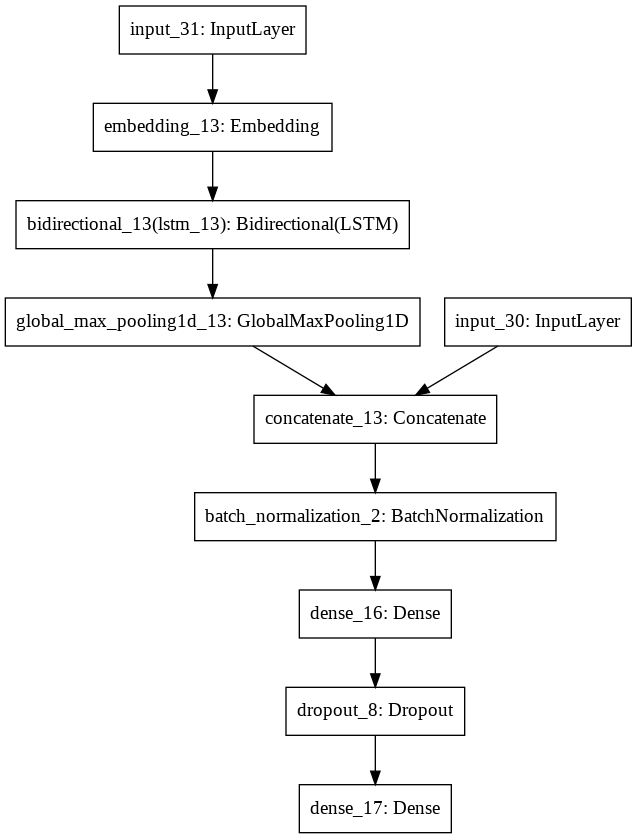

In [66]:
tf.keras.utils.plot_model(get_model(features))


In [67]:
model = get_model(features)


In [70]:
saved_model = "/content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE.best.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early]

In [71]:
history = model.fit([x_train,features], y_train, epochs = 3, batch_size=128, validation_split=0.2, callbacks=callbacks_list)
print('Training progress:')

Epoch 1/3
798/798 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.7106
Epoch 00001: val_accuracy improved from -inf to 0.79617, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE.best.hdf5
798/798 [==============================] - 1467s 2s/step - loss: 0.0560 - accuracy: 0.7106 - val_loss: 0.0519 - val_accuracy: 0.7962
Epoch 2/3
798/798 [==============================] - ETA: 0s - loss: 0.0463 - accuracy: 0.8312
Epoch 00002: val_accuracy improved from 0.79617 to 0.92473, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE.best.hdf5
798/798 [==============================] - 1455s 2s/step - loss: 0.0463 - accuracy: 0.8312 - val_loss: 0.0501 - val_accuracy: 0.9247
Epoch 3/3
798/798 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.8711
Epoch 00003: val_accuracy did not improve from 0.92473
798/798 [==============================] - 1474s 2s/step - loss: 0.0430 - accuracy: 0.8711 - val_loss: 0.0519 - val

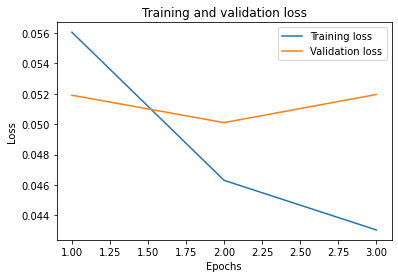

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

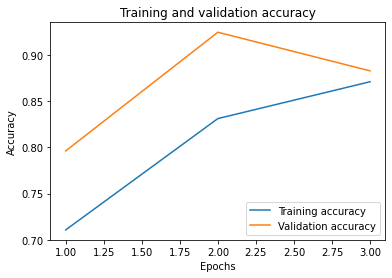

In [73]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [78]:
#load the best model
model = keras.models.load_model(filepath='/content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE.best.hdf5')

In [81]:
score = model.evaluate(x=[x_test,test_features], y= y_test)

print("Loss:", score[0])
print("Test Accuracy:", score[1])

997/997 [==============================] - 106s 106ms/step - loss: 0.0483 - accuracy: 0.9283
Loss: 0.04826586693525314
Test Accuracy: 0.9282780885696411


## Confusion Matrix

In [82]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [84]:
y_pred = model.predict([x_test,test_features])

In [88]:
thresholds = np.arange(0, 1, 0.01)

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
predictions = y_pred
# evaluate each threshold
scores_hl = [hamming_loss(y_test, to_labels(predictions, t)) for t in thresholds]
scores_f1 = [f1_score(y_test, to_labels(predictions, t), average = "macro") for t in thresholds]

# get best threshold
ix_hl = np.argmin(scores_hl)
print('Threshold=%.3f, Hamming Loss=%.5f' % (thresholds[ix_hl], scores_hl[ix_hl]))

ix_f1 = np.argmax(scores_f1)
print('Threshold=%.3f, F1-score=%.5f' % (thresholds[ix_f1], scores_f1[ix_f1]))

Threshold=0.550, Hamming Loss=0.01802
Threshold=0.200, F1-score=0.60056


In [103]:
# convert float to binary integer
predictions = y_pred
thresholds = [0.55]
for val in thresholds:
  y_pred_copy=predictions.copy()

  y_pred_copy[y_pred_copy>=val]=1
  y_pred_copy[y_pred_copy<val]=0

cm = multilabel_confusion_matrix(y_test, y_pred_copy)

In [100]:
cm

array([[[27389,  1366],
        [  404,  2742]],

       [[31314,   270],
        [  142,   175]],

       [[29533,   620],
        [  194,  1554]],

       [[31760,    45],
        [   62,    34]],

       [[29387,   923],
        [  259,  1332]],

       [[31410,   207],
        [  114,   170]]])

In [101]:
def precision_recall(cmat): 
    tn, fp, fn, tp = cmat.ravel()
    return tp/(tp+fp), tp/(tp+fn)

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    #compute tp, tp_and_fn and tp_and_fp w.r.t all classes
    precision, recall = precision_recall(confusion_matrix)

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

    print(class_label)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print()

toxic
Precision: 0.8537650054565297
Recall: 0.7460267005721551

severe_toxic
Precision: 0.6222222222222222
Recall: 0.08832807570977919

obscene
Precision: 0.8494897959183674
Recall: 0.7620137299771167

threat
Precision: 0.25
Recall: 0.020833333333333332

insult
Precision: 0.7574568288854003
Recall: 0.606536769327467

identity_hate
Precision: 0.6790123456790124
Recall: 0.1936619718309859



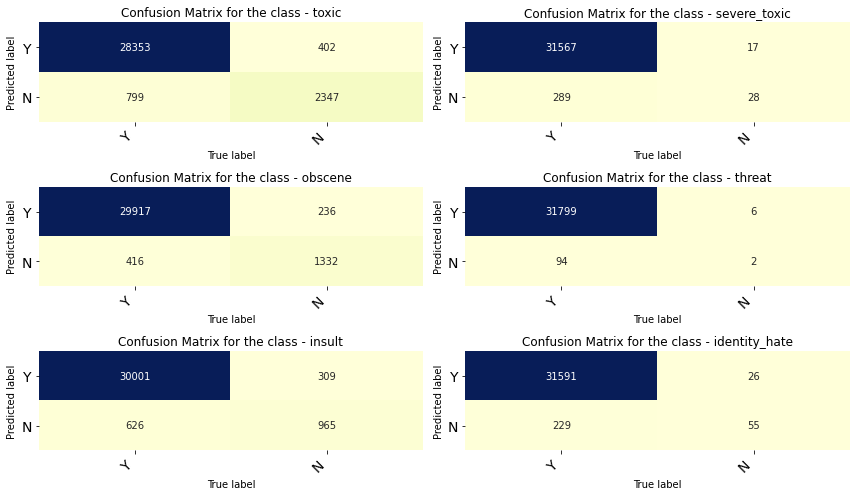

In [104]:
# maximize hamming loss
# use threshold of 0.55
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show()  

toxic
Precision: 0.9524952182229177
Recall: 0.9854639657467708

severe_toxic
Precision: 0.9914513677811551
Recall: 0.9954857578840285

obscene
Precision: 0.9794381985208769
Recall: 0.9934739462441552

threat
Precision: 0.9985851281245087
Recall: 0.998051662371944

insult
Precision: 0.9695480039590894
Recall: 0.9912635768737772

identity_hate
Precision: 0.9934528892684316
Recall: 0.9963837076513132



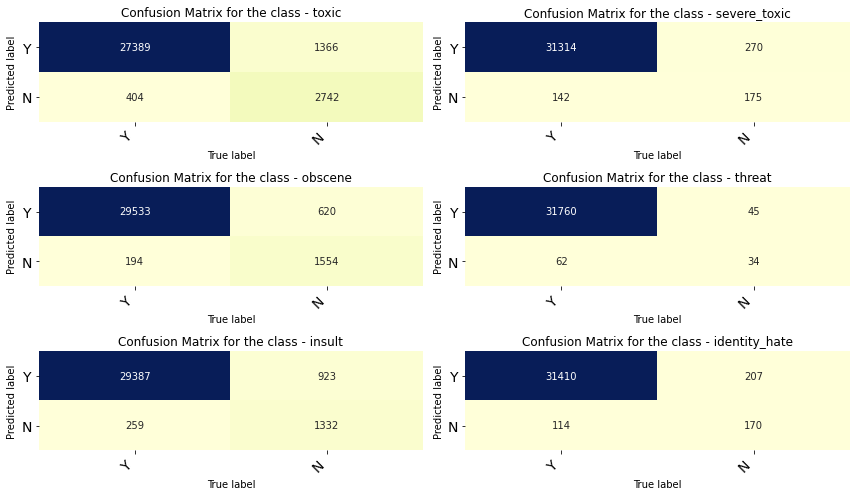

In [99]:
# maximize F score
# use threshold of 0.2
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, labels):

  print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])

fig.tight_layout()
plt.show()  

## Another Model for feature Engineering

In [111]:
def get_model2(features):
    features_input = Input(shape=(features.shape[1],))
    inp = Input(shape=(max_length, ))
    
    # Layer 1: Embedding Layer
    x = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(inp)

    # Layer 2: Bidirectional LSTM
    x, x_h, x_c = LSTM(50, return_sequences=True, return_state= True, dropout=0.1, recurrent_dropout=0.1)(x)
    # Layer 3: A concatenation of maximum pool and engineered features
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, x_h, max_pool,features_input])
    
    x = BatchNormalization()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    
    # Output dense layer.
    outp = Dense(6, activation="sigmoid")(x)

    model = Model(inputs=[inp,features_input], outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model2 = get_model2(features)


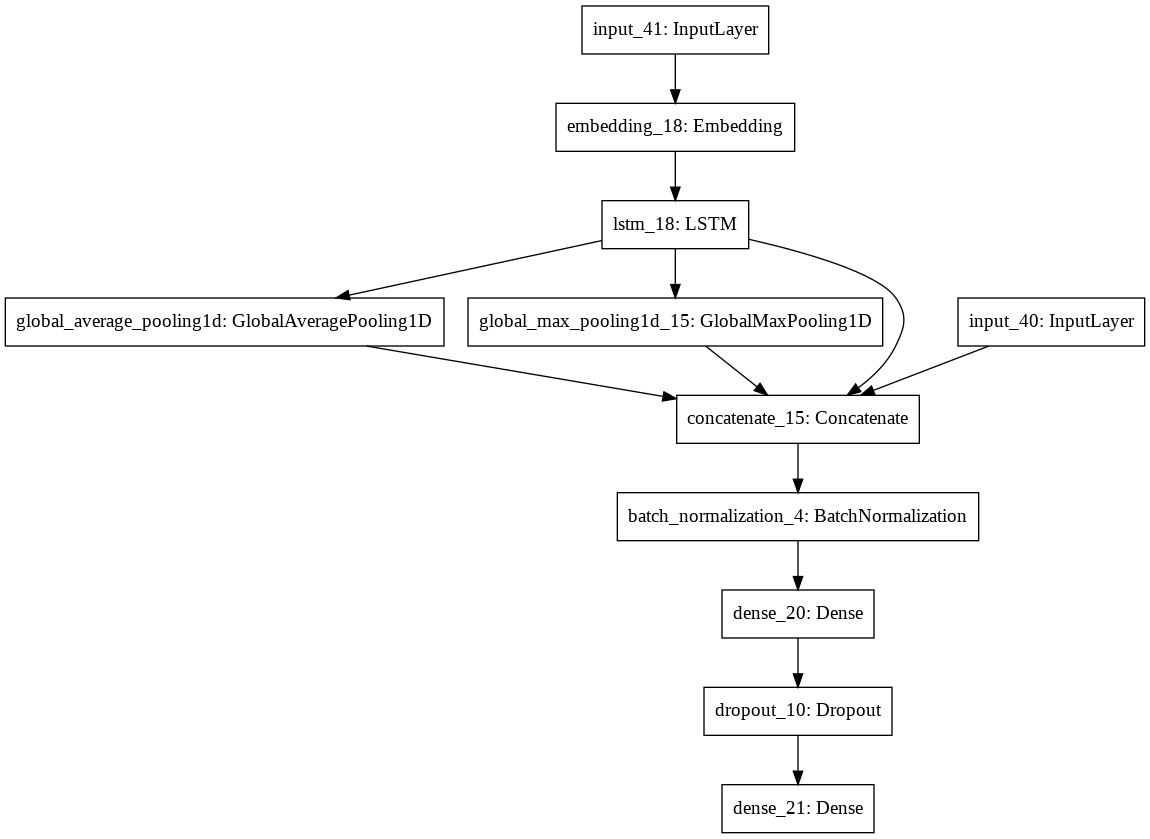

In [112]:
tf.keras.utils.plot_model(model2)

In [113]:
saved_model = "/content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE2.best.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
callbacks_list = [checkpoint, early]

In [114]:
history = model2.fit([x_train,features], y_train, epochs = 3, batch_size=128, validation_split=0.2, callbacks=callbacks_list)
print('Training progress:')

Epoch 1/3
798/798 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.6548
Epoch 00001: val_accuracy improved from -inf to 0.95635, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE2.best.hdf5
798/798 [==============================] - 759s 951ms/step - loss: 0.0731 - accuracy: 0.6548 - val_loss: 0.0515 - val_accuracy: 0.9563
Epoch 2/3
798/798 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.8292
Epoch 00002: val_accuracy improved from 0.95635 to 0.98785, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE2.best.hdf5
798/798 [==============================] - 758s 950ms/step - loss: 0.0485 - accuracy: 0.8292 - val_loss: 0.0542 - val_accuracy: 0.9879
Epoch 3/3
798/798 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.8841
Epoch 00003: val_accuracy improved from 0.98785 to 0.99142, saving model to /content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE2.best.hdf5
798/798 [=============

In [4]:
#load the best model
model = keras.models.load_model(filepath='/content/drive/My Drive/BT4221/Models/LSTM_fasttext_FE2.best.hdf5')

In [5]:
score = model.evaluate(x=[x_test,test_features], y= y_test)

print("Loss:", score[0])
print("Test Accuracy:", score[1])

NameError: ignored

In [117]:
y_pred = model.predict([x_test,test_features])

In [ ]:
thresholds = np.arange(0, 1, 0.01)

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')
 
predictions = y_pred
# evaluate each threshold
scores_hl = [hamming_loss(y_test, to_labels(predictions, t)) for t in thresholds]
scores_f1 = [f1_score(y_test, to_labels(predictions, t), average = "macro") for t in thresholds]

# get best threshold
ix_hl = np.argmin(scores_hl)
print('Threshold=%.3f, Hamming Loss=%.5f' % (thresholds[ix_hl], scores_hl[ix_hl]))

ix_f1 = np.argmax(scores_f1)
print('Threshold=%.3f, F1-score=%.5f' % (thresholds[ix_f1], scores_f1[ix_f1]))

Threshold=0.550, Hamming Loss=0.01802
Threshold=0.200, F1-score=0.60056
